In [14]:
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA


In [15]:
#carrega o dataset
dados = pd.read_csv('/home/erasmor/Área de Trabalho/CSE-CIC-IDS2018/amostras_estratificadas/todos_apenas_baixa_representatividade.csv',sep=",",encoding = 'utf-8',  header=0,na_values='.',dtype={'Label':'category'})
#remove valores infinitos
dados.replace(-np.Inf, np.nan)
#substitui valores NaN
dados.fillna(dados.mean())


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,17,119893441,309629,0,9908128,0,32,32,32.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
1,80,17,119745803,259444,0,8302208,0,32,32,32.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
2,80,17,119965025,248800,0,7961600,0,32,32,32.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
3,80,17,119999991,272337,0,8714784,0,32,32,32.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
4,80,17,119820553,219539,0,7025248,0,32,32,32.000000,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468,3389,6,3868068,14,8,1431,1727,725,0,102.214286,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3469,3389,6,3996691,15,8,1434,1727,725,0,95.600000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3470,3389,6,3945545,14,8,1451,1727,741,0,103.642857,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
3471,3389,6,3972090,14,8,1432,1727,725,0,102.285714,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [16]:
dados.dtypes

Dst Port            int64
Protocol            int64
Flow Duration       int64
Tot Fwd Pkts        int64
Tot Bwd Pkts        int64
                   ...   
Idle Mean         float64
Idle Std          float64
Idle Max            int64
Idle Min            int64
Label            category
Length: 79, dtype: object

In [17]:
dados.memory_usage(deep=True)

Index              128
Dst Port         27784
Protocol         27784
Flow Duration    27784
Tot Fwd Pkts     27784
                 ...  
Idle Mean        27784
Idle Std         27784
Idle Max         27784
Idle Min         27784
Label             3989
Length: 80, dtype: int64

In [18]:
# verifica quantas instâncias (linhas) e quantos atributos (colunas) a base de dados contém
print("numero de linhas e colunas: ",dados.shape)

numero de linhas e colunas:  (3473, 79)


In [19]:
#visualizar distribições por classes contidas no csv - informar nome da classe alvo
print(dados.groupby('Label').size())

Label
Benign                   815
Brute Force -Web         611
Brute Force -XSS         230
DDOS attack-LOIC-UDP    1730
SQL Injection             87
dtype: int64


In [20]:
cols = list(dados.columns)
# colunas que nao serao normalizadas
cols.remove('Label')
# Copiando os dados e aplicando a normalizacao por reescala nas colunas do DataFrame que contem
# valores continuos. Por padrao, o metodo minmax_scale reescala com min=0 e max=1.
dados = dados[~dados.isin([np.nan, np.inf, -np.inf]).any(1)]
dados[cols] = dados[cols].apply(minmax_scale)

In [21]:
#define as colunas de atributos e a coluna da classe (de 0 a 78 são atributos e após a 78 é a classe)
X_raw = dados.iloc[:, :-1].values # atributos
y_raw = dados.iloc[:, 78].values # classe de ataques
X_raw = np.nan_to_num(X_raw.astype(np.float32))

In [22]:
#transformar a variável y com valores categóricos (classses de ataques) em valores numéricos:
labelencoder_y = LabelEncoder()
y_raw = labelencoder_y.fit_transform(y_raw)

In [23]:
# Instanciando um PCA. O parametro n_components indica a quantidade de dimensoes que a base
# original sera reduzida.
pca = PCA(n_components=10, whiten=True,random_state=42)

In [24]:
# Aplicando o pca na base de dados. O atributo 'values' retorna um numpy.array
# de duas dimensões (matriz) contendo apenas os valores numericos do DataFrame.
X_raw = pca.fit_transform(X_raw)

In [25]:
def uncertain_sampling_knn(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classifier, t_inicial):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import LinearSVC
    from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
    import functools
    from IPython.display import clear_output
    
    #define nome de arquivos para salvar
    indica_pool=str(idx_dobra)
           
    # recupera as amostras de treino iniciais - a extratificação realizada só serve para tal finalidade.
    # No caso força a buscar pelo menos uma amostras de cada rótulo disponível (train_size= len(np.unique(y_raw)).
    # Realizar a busca aleatoriamente não garante iniciar com uma instância de cada classe.
    # X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]], train_size= len(np.unique(y_raw)) + t_inicial, stratify = y_raw[idx_data[idx_dobra][TRAIN]])
    #print("tamanho de X_train inicial: ",X_train.shape)
    
    # recupera amostras de teste de acordo com a dobra em uso
    X_teste, y_teste = X_raw[idx_data[idx_dobra][TEST]], y_raw[idx_data[idx_dobra][TEST]]
    # recupera amostras de treino (bruto) de acordo com a dobra em uso
    X_treino, y_treino = X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]]
    
    #isola exemplos para treinamento inicial
    n_labeled_examples = X_treino.shape[0]
    training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=5)
    
    X_train = X_treino[training_indices]
    y_train = y_treino[training_indices]
    
    #Isole os exemplos do pool para consultar
    
    X_pool = np.delete(X_treino, training_indices, axis=0)
    y_pool = np.delete(y_treino, training_indices, axis=0)
   
    #instanciando classificadores de aprendizado ativo
    learner_knn = ActiveLearner(estimator=KNeighborsClassifier(n_neighbors=5),X_training=X_train, y_training=y_train)
    arquivo_performance_knn = open("uncertain_performance_knn_dobra_"+indica_pool+".txt","a")
    arquivo_history_knn = ("uncertain_history_knn_dobra_"+indica_pool+".csv")
    titulo_grafico = 'Incremental classification accuracy KNN'
    
    #Registro da pontuação na porção de teste com o treinamento inicial
    uncertain_sample_score_knn = learner_knn.score(X_teste, y_teste)
    performance_history_knn.append(uncertain_sample_score_knn)
    
    # define tamanho fixo de consultas para aprendizado
    n_queries = QUERIES
    
    #inicio aprendizado ativo
     
    #for index in range(n_amostras_pool):
    for index in range(n_queries):
        #recupera amostras do pool baseado na estratégia de consulta
        query_index, query_instance = learner_knn.query(X_pool)
        
        # Ensina ao modelo ActiveLearner o registro solicitado (amostras vão para o topo).
        learner_knn.teach(X=X_pool[query_index].reshape(1, -1),y=y_pool[query_index].reshape(1, ))
        
        # apaga os registros consultados evitando que seja reconsultados
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)
        
        # verifica a performance no conjunto de validação visto que o modelo foi treinado com novos dados
        uncertain_sample_score_knn = learner_knn.score(X_teste, y_teste)
        predictions = learner_knn.predict(X_teste)
        clear_output(wait=True)
        print ('Accuracy KNN after query no. %d: %f' % (index+1, uncertain_sample_score_knn))
        #arquivo_performance.write('Accuracy after query no. %d: %f \n' % (index+1,uncertain_sample_score))
        performance_history_knn.append(uncertain_sample_score_knn)
        #print ('Accuracy after query no. %d: %f' % (index+1, accuracy_score(y_test, predictions)))
        arquivo_performance_knn.write('Accuracy after query no. %d: %f \n' % (index+1,accuracy_score(y_teste, predictions)))
        #print ('Precision after query no. %d: %f' % (index+1, precision_score(y_test, predictions,average='macro',zero_division=1)))
        arquivo_performance_knn.write('Precision after query no. %d: %f \n' % (index+1,precision_score(y_teste, predictions,average='macro',zero_division=1)))
        #print ('Recall after query no. %d: %f' % (index+1, recall_score(y_test, predictions, average='macro',zero_division=1)))
        arquivo_performance_knn.write('Recall after query no. %d: %f \n' % (index+1, recall_score(y_teste, predictions, average='macro',zero_division=1)))
        #print ('F1 score after query no. %d: %f' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        #arquivo_performance.write('F1 Score after query no. %d: %f \n' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        f1score= 2*((precision_score(y_teste, predictions,average='macro',zero_division=1)*recall_score(y_teste, predictions, average='macro',zero_division=1))/(precision_score(y_teste, predictions,average='macro',zero_division=1)+recall_score(y_teste, predictions, average='macro',zero_division=1)))
        arquivo_performance_knn.write('F1 score after query no. %d: %f \n' % (index+1, f1score))
        #print ("========================================")
        arquivo_performance_knn.write('======================================== \n')
        #for i in range(2):
            #clear_output(wait=True)
            #print(i,"Aguarde, em execução!", flush=True)                
    
    
    arquivo_performance_knn.write("\n Avaliação final KNN \n")
    arquivo_performance_knn.write(classification_report(y_teste, predictions,zero_division=1))  
    np.savetxt(arquivo_history_knn, performance_history_knn,delimiter=",")
    arquivo_performance_knn.close()
    
def uncertain_sampling_rf(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classifier, t_inicial):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import LinearSVC
    from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
    import functools
    from IPython.display import clear_output
    
    #define nome de arquivos para salvar
    indica_pool=str(idx_dobra)
           
    # recupera as amostras de treino iniciais - a extratificação realizada só serve para tal finalidade.
    # No caso força a buscar pelo menos uma amostras de cada rótulo disponível (train_size= len(np.unique(y_raw)).
    # Realizar a busca aleatoriamente não garante iniciar com uma instância de cada classe.
    #X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]], train_size= len(np.unique(y_raw)) + t_inicial, stratify = y_raw[idx_data[idx_dobra][TRAIN]])
  
    # recupera amostras de teste de acordo com a dobra em uso
    X_teste, y_teste = X_raw[idx_data[idx_dobra][TEST]], y_raw[idx_data[idx_dobra][TEST]]
    # recupera amostras de treino (bruto) de acordo com a dobra em uso
    X_treino, y_treino = X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]]
    
    #isola exemplos para treinamento inicial
    n_labeled_examples = X_treino.shape[0]
    training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=5)
    
    X_train = X_treino[training_indices]
    y_train = y_treino[training_indices]
    
    #Isole os exemplos do pool para consultar
    
    X_pool = np.delete(X_treino, training_indices, axis=0)
    y_pool = np.delete(y_treino, training_indices, axis=0)
    
    #instanciando classificadores de aprendizado ativo
    learner_rf = ActiveLearner(estimator=RandomForestClassifier(random_state=42, n_estimators= 5, max_depth=5),X_training=X_train, y_training=y_train)
    arquivo_performance_rf = open("uncertain_performance_rf_dobra_"+indica_pool+".txt","a")
    arquivo_history_rf = ("uncertain_history_rf_dobra_"+indica_pool+".csv")
    titulo_grafico_rf = 'Incremental classification accuracy RF'
                
    #Registro da pontuação na porção de teste com o treinamento inicial
    uncertain_sample_score_rf = learner_rf.score(X_teste, y_teste)
    performance_history_rf.append(uncertain_sample_score_rf)
   
    # define tamanho fixo de consultas para aprendizado
    n_queries = QUERIES
    
    #inicio aprendizado ativo
     
    #for index in range(n_amostras_pool):
    for index in range(n_queries):
        #recupera amostras do pool baseado na estratégia de consulta
        query_index, query_instance = learner_rf.query(X_pool)
        
        # Ensina ao modelo ActiveLearner o registro solicitado (amostras vão para o topo).
        learner_rf.teach(X=X_pool[query_index].reshape(1, -1),y=y_pool[query_index].reshape(1, ))
        
        # apaga os registros consultados evitando que seja reconsultados
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)
        
        # verifica a performance no conjunto de validação visto que o modelo foi treinado com novos dados
        uncertain_sample_score_rf = learner_rf.score(X_teste, y_teste)
        predictions = learner_rf.predict(X_teste)
        clear_output(wait=True)
        print ('Accuracy RF after query no. %d: %f' % (index+1, uncertain_sample_score_rf))
        #arquivo_performance.write('Accuracy after query no. %d: %f \n' % (index+1,uncertain_sample_score))
        performance_history_rf.append(uncertain_sample_score_rf)
        #print ('Accuracy after query no. %d: %f' % (index+1, accuracy_score(y_test, predictions)))
        arquivo_performance_rf.write('Accuracy after query no. %d: %f \n' % (index+1,accuracy_score(y_teste, predictions)))
        #print ('Precision after query no. %d: %f' % (index+1, precision_score(y_test, predictions,average='macro',zero_division=1)))
        arquivo_performance_rf.write('Precision after query no. %d: %f \n' % (index+1,precision_score(y_teste, predictions,average='macro',zero_division=1)))
        #print ('Recall after query no. %d: %f' % (index+1, recall_score(y_test, predictions, average='macro',zero_division=1)))
        arquivo_performance_rf.write('Recall after query no. %d: %f \n' % (index+1, recall_score(y_teste, predictions, average='macro',zero_division=1)))
        #print ('F1 score after query no. %d: %f' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        #arquivo_performance.write('F1 Score after query no. %d: %f \n' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        f1score= 2*((precision_score(y_teste, predictions,average='macro',zero_division=1)*recall_score(y_teste, predictions, average='macro',zero_division=1))/(precision_score(y_teste, predictions,average='macro',zero_division=1)+recall_score(y_teste, predictions, average='macro',zero_division=1)))
        arquivo_performance_rf.write('F1 score after query no. %d: %f \n' % (index+1, f1score))
        #print ("========================================")
        arquivo_performance_rf.write('======================================== \n')
        #for i in range(2):
            #clear_output(wait=True)
            #print(i,"Aguarde, em execução!", flush=True)                
        
    arquivo_performance_rf.write("\n Avaliação final RF \n")
    arquivo_performance_rf.write(classification_report(y_teste, predictions,zero_division=1))  
    np.savetxt(arquivo_history_rf, performance_history_rf,delimiter=",")
    arquivo_performance_rf.close()
    
def uncertain_sampling_tree(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classifier, t_inicial):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.svm import LinearSVC
    from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
    import functools
    from IPython.display import clear_output
    
    #define nome de arquivos para salvar
    indica_pool=str(idx_dobra)
           
    # recupera as amostras de treino iniciais - a extratificação realizada só serve para tal finalidade.
    # No caso força a buscar pelo menos uma amostras de cada rótulo disponível (train_size= len(np.unique(y_raw)).
    # Realizar a busca aleatoriamente não garante iniciar com uma instância de cada classe.
    #X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]], train_size= len(np.unique(y_raw)) + t_inicial, stratify = y_raw[idx_data[idx_dobra][TRAIN]])
    #print("tamanho de X_train inicial: ",X_train.shape)
    
    # recupera amostras de teste de acordo com a dobra em uso
    X_teste, y_teste = X_raw[idx_data[idx_dobra][TEST]], y_raw[idx_data[idx_dobra][TEST]]
    # recupera amostras de treino (bruto) de acordo com a dobra em uso
    X_treino, y_treino = X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]]
    
    #isola exemplos para treinamento inicial
    n_labeled_examples = X_treino.shape[0]
    training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=5)
    
    X_train = X_treino[training_indices]
    y_train = y_treino[training_indices]
    
    #Isole os exemplos do pool para consultar
    
    X_pool = np.delete(X_treino, training_indices, axis=0)
    y_pool = np.delete(y_treino, training_indices, axis=0)
    
    #instanciando classificadores de aprendizado ativo
    learner_tree = ActiveLearner(estimator=DecisionTreeClassifier(max_depth=5,min_samples_split=2,min_samples_leaf=2),X_training=X_train, y_training=y_train)
    arquivo_performance_tree = open("uncertain_performance_tree_dobra_"+indica_pool+".txt","a")
    arquivo_history_tree = ("uncertain_history_tree_dobra_"+indica_pool+".csv")
    titulo_grafico_tree = 'Incremental classification accuracy TREE'
    
    #Registro da pontuação na porção de teste com o treinamento inicial
    uncertain_sample_score_tree = learner_tree.score(X_teste, y_teste)
    performance_history_tree.append(uncertain_sample_score_tree)
    
    # define tamanho fixo de consultas para aprendizado
    n_queries = QUERIES
    
    #inicio aprendizado ativo
     
    #for index in range(n_amostras_pool):
    for index in range(n_queries):
        #recupera amostras do pool baseado na estratégia de consulta
        query_index, query_instance = learner_tree.query(X_pool)
        
        # Ensina ao modelo ActiveLearner o registro solicitado (amostras vão para o topo).
        learner_tree.teach(X=X_pool[query_index].reshape(1, -1),y=y_pool[query_index].reshape(1, ))
        
        # apaga os registros consultados evitando que seja reconsultados
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)
        
        # verifica a performance no conjunto de validação visto que o modelo foi treinado com novos dados
        uncertain_sample_score_tree = learner_tree.score(X_teste, y_teste)
        predictions = learner_tree.predict(X_teste)
        clear_output(wait=True)
        print ('Accuracy TREE after query no. %d: %f' % (index+1, uncertain_sample_score_tree))
        #arquivo_performance.write('Accuracy after query no. %d: %f \n' % (index+1,uncertain_sample_score))
        performance_history_tree.append(uncertain_sample_score_tree)
        #print ('Accuracy after query no. %d: %f' % (index+1, accuracy_score(y_test, predictions)))
        arquivo_performance_tree.write('Accuracy after query no. %d: %f \n' % (index+1,accuracy_score(y_teste, predictions)))
        #print ('Precision after query no. %d: %f' % (index+1, precision_score(y_test, predictions,average='macro',zero_division=1)))
        arquivo_performance_tree.write('Precision after query no. %d: %f \n' % (index+1,precision_score(y_teste, predictions,average='macro',zero_division=1)))
        #print ('Recall after query no. %d: %f' % (index+1, recall_score(y_test, predictions, average='macro',zero_division=1)))
        arquivo_performance_tree.write('Recall after query no. %d: %f \n' % (index+1, recall_score(y_teste, predictions, average='macro',zero_division=1)))
        #print ('F1 score after query no. %d: %f' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        #arquivo_performance.write('F1 Score after query no. %d: %f \n' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        f1score= 2*((precision_score(y_teste, predictions,average='macro',zero_division=1)*recall_score(y_teste, predictions, average='macro',zero_division=1))/(precision_score(y_teste, predictions,average='macro',zero_division=1)+recall_score(y_teste, predictions, average='macro',zero_division=1)))
        arquivo_performance_tree.write('F1 score after query no. %d: %f \n' % (index+1, f1score))
        #print ("========================================")
        arquivo_performance_tree.write('======================================== \n')
        #for i in range(2):
            #clear_output(wait=True)
            #print(i,"Aguarde, em execução!", flush=True)                
        
    arquivo_performance_tree.write("\n Avaliação final TREE \n")
    arquivo_performance_tree.write(classification_report(y_teste, predictions,zero_division=1))  
    np.savetxt(arquivo_history_tree, performance_history_tree,delimiter=",")
    arquivo_performance_tree.close()

def uncertain_sampling_mlp(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classifier, t_inicial):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.svm import LinearSVC
    from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
    import functools
    from IPython.display import clear_output
    
    #define nome de arquivos para salvar
    indica_pool=str(idx_dobra)
           
    # recupera as amostras de treino iniciais - a extratificação realizada só serve para tal finalidade.
    # No caso força a buscar pelo menos uma amostras de cada rótulo disponível (train_size= len(np.unique(y_raw)).
    # Realizar a busca aleatoriamente não garante iniciar com uma instância de cada classe.
    #X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]], train_size= len(np.unique(y_raw)) + t_inicial, stratify = y_raw[idx_data[idx_dobra][TRAIN]])
    #print("tamanho de X_train inicial: ",X_train.shape)
    
    # recupera amostras de teste de acordo com a dobra em uso
    X_teste, y_teste = X_raw[idx_data[idx_dobra][TEST]], y_raw[idx_data[idx_dobra][TEST]]
    # recupera amostras de treino (bruto) de acordo com a dobra em uso
    X_treino, y_treino = X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]]
    
    #isola exemplos para treinamento inicial
    n_labeled_examples = X_treino.shape[0]
    training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=5)
    
    X_train = X_treino[training_indices]
    y_train = y_treino[training_indices]
    
    #Isole os exemplos do pool para consultar
    
    X_pool = np.delete(X_treino, training_indices, axis=0)
    y_pool = np.delete(y_treino, training_indices, axis=0)
    
    #instanciando classificadores de aprendizado ativo
    learner_mlp = ActiveLearner(estimator=MLPClassifier(max_iter = 2000),X_training=X_train, y_training=y_train)
    arquivo_performance_mlp = open("uncertain_performance_mlp_dobra_"+indica_pool+".txt","a")
    arquivo_history_mlp = ("uncertain_history_mlp_dobra_"+indica_pool+".csv")

    
    #Registro da pontuação na porção de teste com o treinamento inicial
    uncertain_sample_score_mlp = learner_mlp.score(X_teste, y_teste)
    performance_history_mlp.append(uncertain_sample_score_mlp)
    
    # define tamanho fixo de consultas para aprendizado
    n_queries = QUERIES
    
    #inicio aprendizado ativo
     
    #for index in range(n_amostras_pool):
    for index in range(n_queries):
        #recupera amostras do pool baseado na estratégia de consulta
        query_index, query_instance = learner_mlp.query(X_pool)
        
        # Ensina ao modelo ActiveLearner o registro solicitado (amostras vão para o topo).
        learner_mlp.teach(X=X_pool[query_index].reshape(1, -1),y=y_pool[query_index].reshape(1, ))
        
        # apaga os registros consultados evitando que seja reconsultados
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)
        
        # verifica a performance no conjunto de validação visto que o modelo foi treinado com novos dados
        uncertain_sample_score_mlp = learner_mlp.score(X_teste, y_teste)
        predictions = learner_mlp.predict(X_teste)
        clear_output(wait=True)
        print ('Accuracy MLP after query no. %d: %f' % (index+1, uncertain_sample_score_mlp))
        #arquivo_performance.write('Accuracy after query no. %d: %f \n' % (index+1,uncertain_sample_score))
        performance_history_mlp.append(uncertain_sample_score_mlp)
        #print ('Accuracy after query no. %d: %f' % (index+1, accuracy_score(y_test, predictions)))
        arquivo_performance_mlp.write('Accuracy after query no. %d: %f \n' % (index+1,accuracy_score(y_teste, predictions)))
        #print ('Precision after query no. %d: %f' % (index+1, precision_score(y_test, predictions,average='macro',zero_division=1)))
        arquivo_performance_mlp.write('Precision after query no. %d: %f \n' % (index+1,precision_score(y_teste, predictions,average='macro',zero_division=1)))
        #print ('Recall after query no. %d: %f' % (index+1, recall_score(y_test, predictions, average='macro',zero_division=1)))
        arquivo_performance_mlp.write('Recall after query no. %d: %f \n' % (index+1, recall_score(y_teste, predictions, average='macro',zero_division=1)))
        #print ('F1 score after query no. %d: %f' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        #arquivo_performance.write('F1 Score after query no. %d: %f \n' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        f1score= 2*((precision_score(y_teste, predictions,average='macro',zero_division=1)*recall_score(y_teste, predictions, average='macro',zero_division=1))/(precision_score(y_teste, predictions,average='macro',zero_division=1)+recall_score(y_teste, predictions, average='macro',zero_division=1)))
        arquivo_performance_mlp.write('F1 score after query no. %d: %f \n' % (index+1, f1score))
        #print ("========================================")
        arquivo_performance_mlp.write('======================================== \n')
        #for i in range(2):
            #clear_output(wait=True)
            #print(i,"Aguarde, em execução!", flush=True)                
        
    arquivo_performance_mlp.write("\n Avaliação final MLP \n")
    arquivo_performance_mlp.write(classification_report(y_teste, predictions,zero_division=1))  
    np.savetxt(arquivo_history_mlp, performance_history_mlp,delimiter=",")
    arquivo_performance_mlp.close() 

def uncertain_sampling_xgb(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classifier, t_inicial):
    
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.svm import LinearSVC
    from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
    import functools
    from IPython.display import clear_output
    
    #define nome de arquivos para salvar
    indica_pool=str(idx_dobra)
           
    # recupera as amostras de treino iniciais - a extratificação realizada só serve para tal finalidade.
    # No caso força a buscar pelo menos uma amostras de cada rótulo disponível (train_size= len(np.unique(y_raw)).
    # Realizar a busca aleatoriamente não garante iniciar com uma instância de cada classe.
    #X_train, X_test, y_train, y_test = train_test_split(X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]], train_size= len(np.unique(y_raw)) + t_inicial, stratify = y_raw[idx_data[idx_dobra][TRAIN]])
    #print("tamanho de X_train inicial: ",X_train.shape)
    
    # recupera amostras de teste de acordo com a dobra em uso
    X_teste, y_teste = X_raw[idx_data[idx_dobra][TEST]], y_raw[idx_data[idx_dobra][TEST]]
    # recupera amostras de treino (bruto) de acordo com a dobra em uso
    X_treino, y_treino = X_raw[idx_data[idx_dobra][TRAIN]], y_raw[idx_data[idx_dobra][TRAIN]]
    
    #isola exemplos para treinamento inicial
    n_labeled_examples = X_treino.shape[0]
    training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=5)
    
    X_train = X_treino[training_indices]
    y_train = y_treino[training_indices]
    
    #Isole os exemplos do pool para consultar
    
    X_pool = np.delete(X_treino, training_indices, axis=0)
    y_pool = np.delete(y_treino, training_indices, axis=0)
    
    #instanciando classificadores de aprendizado ativo
    learner_xgb = ActiveLearner(estimator=XGBClassifier(num_class=4,learning_rate=0.1,max_depth=10,eval_metric='mlogloss',objective= 'multi:softprob'),X_training=X_train, y_training=y_train)
    arquivo_performance_xgb = open("uncertain_performance_xgb_dobra_"+indica_pool+".txt","a")
    arquivo_history_xgb = ("uncertain_history_xgb_dobra_"+indica_pool+".csv")

    
    #Registro da pontuação na porção de teste com o treinamento inicial
    uncertain_sample_score_xgb = learner_xgb.score(X_teste, y_teste)
    performance_history_xgb.append(uncertain_sample_score_xgb)
    
    # define tamanho fixo de consultas para aprendizado
    n_queries = QUERIES
    
    #inicio aprendizado ativo
     
    #for index in range(n_amostras_pool):
    for index in range(n_queries):
        #recupera amostras do pool baseado na estratégia de consulta
        query_index, query_instance = learner_xgb.query(X_pool)
        
        # Ensina ao modelo ActiveLearner o registro solicitado (amostras vão para o topo).
        learner_xgb.teach(X=X_pool[query_index].reshape(1, -1),y=y_pool[query_index].reshape(1, ))
        
        # apaga os registros consultados evitando que seja reconsultados
        X_pool = np.delete(X_pool, query_index, axis=0)
        y_pool = np.delete(y_pool, query_index)
        
        # verifica a performance no conjunto de validação visto que o modelo foi treinado com novos dados
        uncertain_sample_score_xgb = learner_xgb.score(X_teste, y_teste)
        predictions = learner_xgb.predict(X_teste)
        clear_output(wait=True)
        print ('Accuracy XGB after query no. %d: %f' % (index+1, uncertain_sample_score_xgb))
        #arquivo_performance.write('Accuracy after query no. %d: %f \n' % (index+1,uncertain_sample_score))
        performance_history_xgb.append(uncertain_sample_score_xgb)
        #print ('Accuracy after query no. %d: %f' % (index+1, accuracy_score(y_test, predictions)))
        arquivo_performance_xgb.write('Accuracy after query no. %d: %f \n' % (index+1,accuracy_score(y_teste, predictions)))
        #print ('Precision after query no. %d: %f' % (index+1, precision_score(y_test, predictions,average='macro',zero_division=1)))
        arquivo_performance_xgb.write('Precision after query no. %d: %f \n' % (index+1,precision_score(y_teste, predictions,average='macro',zero_division=1)))
        #print ('Recall after query no. %d: %f' % (index+1, recall_score(y_test, predictions, average='macro',zero_division=1)))
        arquivo_performance_xgb.write('Recall after query no. %d: %f \n' % (index+1, recall_score(y_teste, predictions, average='macro',zero_division=1)))
        #print ('F1 score after query no. %d: %f' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        #arquivo_performance.write('F1 Score after query no. %d: %f \n' % (index+1, f1_score(y_test, predictions,average='macro',zero_division=1)))
        f1score= 2*((precision_score(y_teste, predictions,average='macro',zero_division=1)*recall_score(y_teste, predictions, average='macro',zero_division=1))/(precision_score(y_teste, predictions,average='macro',zero_division=1)+recall_score(y_teste, predictions, average='macro',zero_division=1)))
        arquivo_performance_xgb.write('F1 score after query no. %d: %f \n' % (index+1, f1score))
        #print ("========================================")
        arquivo_performance_xgb.write('======================================== \n')
        #for i in range(2):
            #clear_output(wait=True)
            #print(i,"Aguarde, em execução!", flush=True)                
        
    arquivo_performance_xgb.write("\n Avaliação final XGB \n")
    arquivo_performance_xgb.write(classification_report(y_teste, predictions,zero_division=1))  
    np.savetxt(arquivo_history_xgb, performance_history_xgb,delimiter=",")
    arquivo_performance_xgb.close()
    
import time
import sys
import threading
from datetime import datetime
from datetime import date

from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from modAL.uncertainty import classifier_uncertainty
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from timeit import Timer
import time
import functools
# importing the multiprocessing module
import multiprocessing

#inicia relogio
t1 = time.time()
# Define o tamanho das divisões feitas no dataset (cross-validation)
n_dobras = 10
# Define Tamanho inicial da amostra (toda estratégia parte de um tamanho mínimo).
t_inicial = 10
#define array de performance
performance_history = []
#define array de indices das partições
idx_data =[]
# cross validation bags - n_splits
data_cv = StratifiedShuffleSplit(n_splits= n_dobras, random_state=42) 
data_cv.get_n_splits(X_raw, y_raw)
# chame a instância e gere os dados sobre a base original
type(data_cv.split(X_raw, y_raw))
# dividir os dados - A função split.split () retorna índices para amostras de treino e amostras de teste. 
# Ele examinará o número de validação cruzada especificado e retornará cada vez que treinar 
# e testar os índices de amostra usando os conjuntos de dados de treinamento e teste que podem 
# ser criados filtrando o conjunto de dados inteiro. Por exemplo idx_data[0][1], o primeiro indice faz referencia
# a dobra e o segundo indice faz referencia a posição da dobra (0 = treino e 1 = teste). Logo TRAIN=0 e TEST=1.
for train_index, test_index in data_cv.split(X_raw,y_raw):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #print("n_split",n_splits,"TRAIN:", train_index, "TEST:", test_index)
    idx_data.append([train_index, test_index])
#verifica tamanho das dobras (numero de instâncias de cada dobra)
#print("tamanho de cada dobra: ",idx_data[3][0].shape)

TRAIN =0
TEST =1

# DEFINE NUMERO DE QUERIES
QUERIES = 30
#define arrays
performance_history_knn =[]
performance_history_rf =[]
performance_history_tree =[]
performance_history_mlp = []
performance_history_xgb = []

#chama procedimento de aprendizado para todas as dobras
#classificadores=['knn'] 
classificador_knn ="knn"
classificador_rf ="rf"
classificador_nb ="nb"
classificador_tree ="tree"
classificador_mlp ="mlp"
classificador_xgb ="xgb"
#classificadores=['knn','rf','nb','tree']
#for classificador in classificadores:
#    classifier = classificador
#    for idx_dobra in range(n_splits):
        #uncertain_sampling(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classifier, init_size)
#for idx_dobra in range(n_dobras):
#for idx_dobra in range(1):    
#    if __name__ == "__main__":
#        # criando os processos
#        p1 = multiprocessing.Process(target=uncertain_sampling_knn(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_knn, t_inicial))
#        p2 = multiprocessing.Process(target=uncertain_sampling_rf(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_rf, t_inicial))
#        #p3 = multiprocessing.Process(target=uncertain_sampling_nb(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_nb, t_inicial))
#        p4 = multiprocessing.Process(target=uncertain_sampling_tree(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_tree, t_inicial))
#        p5 = multiprocessing.Process(target=uncertain_sampling_mlp(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_mlp, t_inicial))
        
        # iniciando os processos
#        p1.start()
#        p2.start()
        #p3.start()
#        p4.start()
#        p5.start()
        
        # aguardando os processos serem finalizados
#        p1.join()
#        p2.join()
        #p3.join()
#        p4.join()
#        p5.join()
                   
        # todos os processos finalizados
#        print("Terminado!")
for idx_dobra in range(1):    
    threading.Thread(target=uncertain_sampling_knn(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_knn, t_inicial)).start()
    threading.Thread(target=uncertain_sampling_rf(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_rf, t_inicial)).start()
    #threading.Thread(target=uncertain_sampling_nb(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_nb, t_inicial)).start()
    threading.Thread(target=uncertain_sampling_mlp(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_mlp, t_inicial)).start()
    threading.Thread(target=uncertain_sampling_tree(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_xgb, t_inicial)).start()
    threading.Thread(target=uncertain_sampling_xgb(X_raw, y_raw, idx_data, idx_dobra, TRAIN, TEST, classificador_tree, t_inicial)).start()

t2 = time.time()
time_elapsed = (t2-t1)/3600
print("tempo: ",time_elapsed)


Accuracy XGB after query no. 30: 0.801724
tempo:  0.018231366276741028


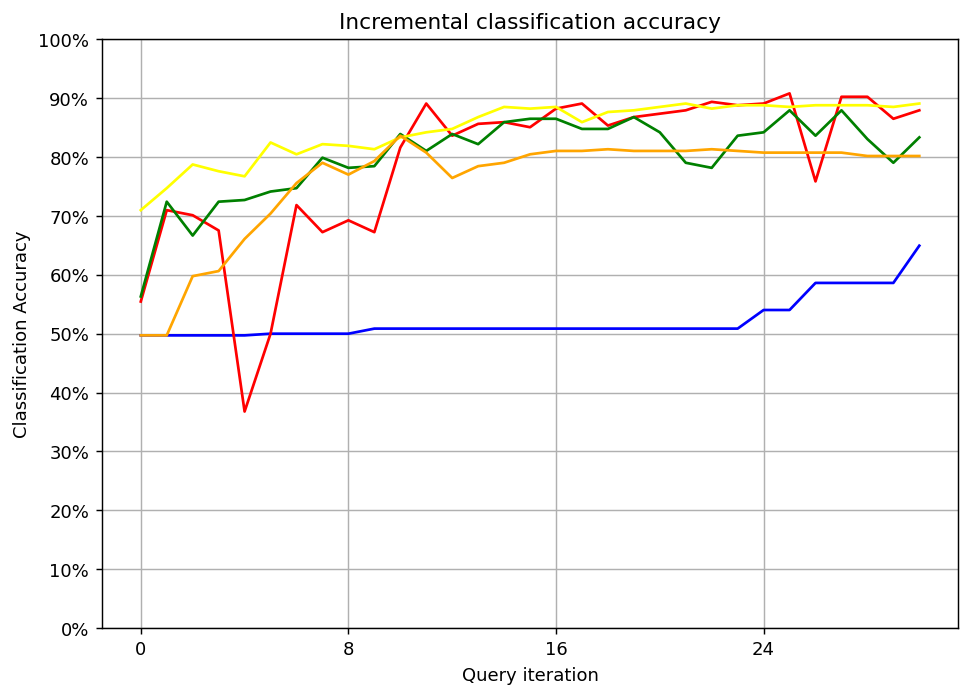

In [26]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_knn,color="blue")
ax.plot(performance_history_rf,color="red")
ax.plot(performance_history_tree,color="green")
ax.plot(performance_history_mlp,color="yellow")
ax.plot(performance_history_xgb,color="orange")
ax.scatter(range(len(performance_history_knn)), performance_history_knn,s=0)
ax.scatter(range(len(performance_history_rf)), performance_history_rf, s=0)
ax.scatter(range(len(performance_history_tree)), performance_history_tree,s=0)
ax.scatter(range(len(performance_history_mlp)), performance_history_mlp,s=0)
ax.scatter(range(len(performance_history_xgb)), performance_history_xgb,s=0)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()